# Classical Shadows - code prototype

This is a prototpye for the *classical shadows* module that we plan to implement in Mitiq. 

Within this notebook, we employ the Cirq and Mitiq framework to obtain classical shadows of a quantum state, which are essential for the processes of state reconstruction and estimation of observables.


The assocaited RFC can be found at [this link](https://docs.google.com/document/d/1B5FnqQDvoRYap5fGPqzcbp-RXIrUFjbBcLiWIUrLmuA/edit?usp=sharing).
    

In [1]:
import cirq
import numpy as np
from copy import deepcopy
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Union, Dict, Any

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from mitiq.shadows import *

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
%matplotlib inline
# auto reload modules when they have changed
# np.random.seed(666)
%load_ext autoreload
%autoreload 2

In the context of an $n$-qubit system, where $\rho$ is an unknown quantum state residing in a $2^n$-dimensional Hilbert space, the procedure of performing classical shadow involves extracting information from the state through repeated measurements. 

## Define a test circuit from which we'll extract classical shadows



In [2]:
# number of qubits in the circuit
num_qubits: int = 4
# qubits in the circuit prepared in the $|0\rangle$ state
qubits: List[cirq.Qid] = cirq.LineQubit.range(num_qubits)
# defining random parameters for the circuit
# np.random.seed(666)
# params = np.array([0.82418808, 0.479966  , 1.17346801, 0.90904807])
params: np.ndarray = np.random.randn(2 * num_qubits)


# define circuit
def simple_test_circuit(
    params: np.ndarray, qubits: List[cirq.Qid]
) -> cirq.Circuit:
    circuit: cirq.Circuit = cirq.Circuit()
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.H(qubit))
        circuit.append(cirq.ry(params[i])(qubit))
    for i in range(num_qubits - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rz(params[i + num_qubits])(qubit))
    return circuit


# print the circuit
print(simple_test_circuit(params, qubits))

0: ───H───Ry(0.177π)────@───Rz(0.311π)───────────────────────────────
                        │
1: ───H───Ry(-0.052π)───X───@────────────Rz(-0.194π)─────────────────
                            │
2: ───H───Ry(0.086π)────────X────────────@─────────────Rz(-0.205π)───
                                         │
3: ───H───Ry(-1.04π)─────────────────────X─────────────Rz(-0.033π)───


<script>
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
</script>

## Sampling random Pauli measurements 

This process involves applying a random unitary selected from a randomly fixed ensemble $\mathcal{U}\in U(2^n)$ to rotate the state $\rho\rightarrow U^\dagger \rho U$, performing a computational-basis($Z$-basis) measurement, and storing a classical description $U^\dagger |\hat{b}\rangle\langle\hat{b}| U$. After the measurement, the inverse of $U$ is applied to the resulting computational basis state, collapsing $\rho$ to
  
\begin{align}
U^\dagger|\hat{b}\rangle\langle\hat{b}| U\qquad \mathrm{where} \qquad \mathrm{Pr}[\hat{b}=b]=\langle b|U\rho U^\dagger|b\rangle.
\end{align}

If the unitary group $\mathcal{U}$ is chosen to be the local Clifford group $\mathrm{CL}(2)^n$, this corresponds to performing a random Pauli measurement. This means that for each qubit, we randomly decide to measure one of the Pauli operators. Considering that the only possible measurement to be performed is the $Z$-basis measurement, the random Pauli measurement is equivalent to randomly sampling a unitary from the unitary ensemble: $\mathcal{G}=\{\mathrm{id},\;\mathrm{H},\;\mathrm{H}\cdot \mathrm{S}^\dagger\}$ and then performing the $Z$-basis measurement. This is what we do after we perform stage 1 of the main function execute_with_shadows, and the outcomes are stored as two arrays: one for the measurement results $|0\rangle:=1,;|1\rangle:= -1$ and the other for the applied unitaries. In the case of local Pauli measurement, what gets recorded is the measured Pauli gate: $X,Y,Z$. If we conduct this process in two steps, first by sampling the unitary (say $U=\mathrm{H}$ or $\mathrm{H}\cdot \mathrm{S}^\dagger$), and then by performing the $Z$-basis measurement, it becomes equivalent to performing an $X$ or $Y$-basis measurement. So, in terms of implementation, we simply record a sequence of Pauli gates $u_i:= U_i^\dagger ZU_i$ that have been measured for each qubit in the circuit as one of the output lists of the measurement function shadow_measure_with_executor.

## Apply Inverse Channel to Obtain Snapshot and Classical Shadows.

This random measurement contains valuable information about $\rho$ in expectation:
\begin{align}
    \mathbb{E}[U^\dagger |\hat{b}\rangle\langle\hat{b}|U]=\mathcal{M}(\rho),
\end{align}
the expectation in the first expression has the form $\mathbf{Pr}[\hat{{b}}={b}]=\langle {b}|U\rho U^\dagger|b\rangle$. For any unitary ensemble $\mathcal{U}$, the expected value of the outer product of the classical snapshot corresponds to the operation of the quantum channel $\mathcal{M}$ on the quantum state $\rho$. If the measurements we sample from are tomographically complete, then the protocol $\mathcal{M}$ defines an invertible linear transformation $\mathcal{M}^{-1}$, which may not be a quantum channel, since it is not CP, which means that it could not be performed in the lab. But it will only be performed on the classical data stored in
a classical memory. If we apply $\mathcal{M}$ to all the snapshots, the expected value of these inverted snapshots aligns with the density operator as defined by the protocol,

\begin{align}
\hat{\rho}=\mathcal{M}^{-1}\left(U^\dagger|\hat{b}\rangle\langle\hat{b}|U\right)
\end{align}
which has been named a single copy of **classical shadow**. Based on *Schur's Lemma* the quantum channel $\mathcal{M}$ is a depolarizing channel $\mathcal{D}_p$ with $p=\frac{1}{2^n+1}$. It is easy to solve for the inverted map 

\begin{align}
\mathcal{M}^{-1}(\cdot)=[(2^n +1)-\mathbb{I}\cdot\mathrm{Tr}](\cdot),
\end{align}
 which is indeed unitary, however, not CP, so it is not a physical map as expected.

In the case of random Pauli measurement, the unitary could be represented by the tensor product of all qubits, so it is with the state $|\hat{b}\rangle\in\{0,1\}^{\otimes n}$, i.e. $U^\dagger|\hat{b}\rangle=\bigotimes_{i\leq n}U_i|\hat{b}_i\rangle$. Therefore, based on Schur's Lemma, a snapshot would takes the form:
\begin{align}
\hat{\rho}=\bigotimes_{i=1}^{n}\left(3U_i^\dagger|\hat{b}_i\rangle\langle\hat{b}_i|U_i-\mathbb{I}\right),\qquad|\hat{b}_i\rangle\in\{0,1\}.
\end{align}
which is a tensor product of $n$ qubits, each of which is a classical state. This step is realized by `snapshot_state` function. Repeating this procedure $N$ times results in an array of $N$ independent classical snapshots of $\rho$:
\begin{align}
    S(\rho,\; N)=\big\{\hat{\rho}_1=\mathcal{M}^{-1}\left(U_1^\dagger |\hat{b}_1\rangle\langle\hat{b}_1| U_1\right),\dots,\mathcal{M}^{-1}\left(U_N^\dagger |\hat{b}_N\rangle\langle\hat{b}_N| U_N\right)\big\} .
\end{align}

# State Reconstruction from Classical Shadows
### State Reconstruction
The classical shadows state reconstruction are then obtained by taking the average of the snapshots, this process is designed to reproduce the underlying state $\rho$ exactly in expectation:
\begin{align}
   \rho= \mathbb{E}[\hat{\rho}],
\end{align}

In the main function `execute_with_shadows`, we first sample the random Pauli measurement, then apply the inverse channel to obtain the snapshots, and finally take the average of the snapshots to obtain the reconstructed state if *state_reconstruction =* **True**. 

### Error Analysis
We can take a visualization of the elementwise difference between the reconstructed state and the original state. 
\begin{align}
\Delta\rho_{ij}=|\rho^{\mathrm{shadow}}_{ij}-\rho_{ij}|
\end{align}
The difference is very small, which means that the classical shadow is a good approximation of the original state even in the sence of state tomography. 

It is anticipated that the fidelity will not necessarily be lower than 1, as the state reconstructed through classical shadow estimation is not guaranteed to be a physical quantum state, given that $\mathcal{M}^{-1}$ is not a quantum channel. 

Fidelity is defined by $F(\rho,\sigma)=\mathrm{Tr}\sqrt{\rho^{1/2}\sigma\rho^{1/2}}$, when $\rho=|v\rangle\langle v|$ is a pure state $F(\rho,\sigma)=\langle v|\sigma|v\rangle$.
Based on the theorem, if the error rate of fedelity is $\epsilon$, i.e.
\begin{align}
|F(\rho,\sigma)-1|\leq\epsilon,
\end{align}
then the minimumnumber of measurements $N$ (number of snapshots) should be:
\begin{align}
N = \frac{34}{\epsilon^2}\left\|\rho-\frac{\mathrm{Tr}(\rho)}{2^n}\mathbb{I}\right\|_{\mathrm{shadow}}^2
\end{align}
with the shadow norm upper bound of the random Pauli measurement $\left\|\cdot\right\|_{\mathrm{shadow}}\leq 2^k\|\cdot\|_\infty$ when the operator acting on $k$ qubits, we have $N\leq 34\epsilon^{-2}2^{2n}+\mathcal{O}(e^{-n})$. Based on Fuchs–van de Graaf inequalities and properties of $L_p$ norm, $\|\rho-\sigma\|_2\leq \|\rho-\sigma\|_1 \leq (1-F(\rho,\sigma))^{1/2}$, the $L_2$ norm distance between the state reconstructed through classical shadow estimation and the state prepared by the circuit is upperbounded by the fidelity error rate $\epsilon$.

In [3]:
# target state
# Create a simple circuit.
circuit = simple_test_circuit(params, qubits)

# Compute the final state vector.
state_vector = circuit.final_state_vector().reshape(-1, 1)

# Compute the density matrix.
rho_true = state_vector @ state_vector.conj().T

In [4]:
# error rate of state reconstruction epsilon < 1.
epsilon = 1
# number of total measurements should perform for error rate epsilon
n_total_measurements = min_n_total_measurements(epsilon, num_qubits)

print("n_total_measurements = {}".format(n_total_measurements))

n_total_measurements = 8704


In [5]:
# n_total_measurements = 2000

output = execute_with_shadows(
    circuit,
    measurement_total_rounds=n_total_measurements,
    state_reconstruction=True,
)
# shadow reconstruction of the density matrix
rho_shadow = output["est_density_matrix"]

Measurement:   0%|          | 0/8704 [00:00<?, ?it/s]

We can plot the elementwise difference between the reconstructed state and the original state as a thermal diagram:

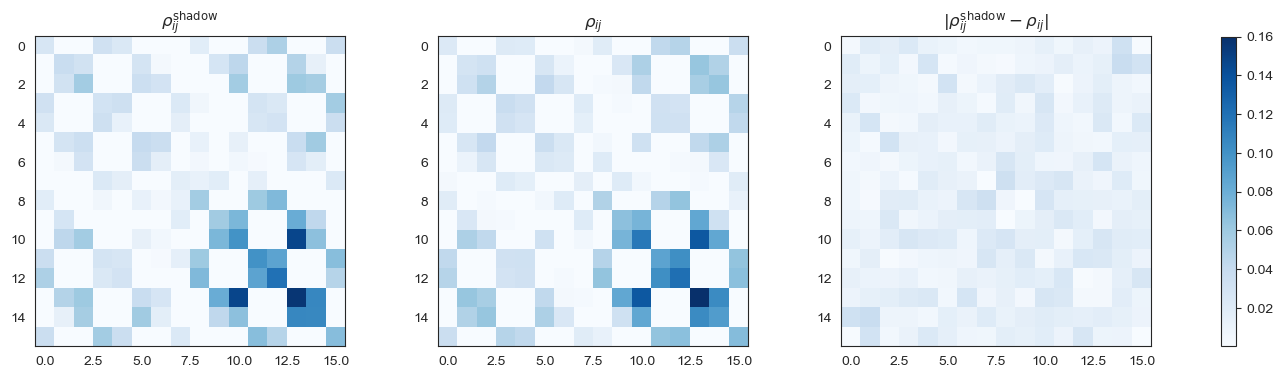

In [6]:
# Setting the style
sns.set_style("white")

# Calculate min and max values across the datasets
vmin = min(
    np.abs(rho_shadow).min(),
    np.abs(rho_true).min(),
    np.abs(rho_true - rho_shadow).min(),
)
vmax = max(
    np.abs(rho_shadow).max(),
    np.abs(rho_true).max(),
    np.abs(rho_true - rho_shadow).max(),
)

# Creating a figure with three subplots (1 row, 3 columns)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plotting the first image on the first subplot
im1 = axs[0].imshow(np.real(rho_shadow), cmap="Blues", vmin=vmin, vmax=vmax)
axs[0].set_title(r"$\rho_{ij}^{\mathrm{shadow}}$")

# Plotting the second image on the second subplot
im2 = axs[1].imshow(np.real(rho_true), cmap="Blues", vmin=vmin, vmax=vmax)
axs[1].set_title(r"$\rho_{ij}$")

# Plotting the third image on the third subplot
im3 = axs[2].imshow(
    np.abs(rho_true - rho_shadow), cmap="Blues", vmin=vmin, vmax=vmax
)
axs[2].set_title(r"$|\rho_{ij}^{\mathrm{shadow}}-\rho_{ij}|$")

# Adjust the space between plots
plt.subplots_adjust(wspace=0.3)

# Add a shared colorbar
cbar = fig.colorbar(
    im3, ax=axs.ravel().tolist(), orientation="vertical", shrink=0.67, pad=0.05
)

# Show the figure with three side-by-side plots
plt.show()

In [7]:
# PAULI_MAP = {"X":0,"Y":1,"Z":2,"I":3}
# paulis = []
# for string in output['pauli_strings']:
#     paulis.append([PAULI_MAP[string[0]],PAULI_MAP[string[1]]])
# paulis = np.array(paulis)
# outcomes = np.concatenate([paulis,output['shadow_outcomes']],axis=1)
# np.unique(output['pauli_strings'],axis=0,return_counts=True)
# combinations, counts = np.unique(outcomes,axis=0,return_counts=True)
# assert len(combinations) == 36
# wrong_counts = [ 26,  13,  47, 121,   6,  52,  38, 125,  46, 139,   7,  30,   5,
#         76,  23, 100,  17,  24,  38, 176,  24, 184,   3,  19,  32,  57,
#         51,  84,   5,  67,  47,  92,  45,  34, 138,   9]

# # order =
# order = np.array([29, 19, 25, 33, 15,  3,  7, 23, 11,  5, 22,  9,  1, 10, 32, 24, 21,
#        14, 13,  0, 17, 28,  6, 27, 31,  8, 16, 34,  2, 18, 12, 35, 26, 20,
#         4, 30])
# plt.plot(counts[order],marker='o')

Compute the fidelity and $L_2$ distance between the state reconstructed through classical shadow estimation (which is not a quantum state) and the state prepared by the circuit $\|\rho_{\mathrm{shadow}}-\rho\|_2$, with $\|\cdot\|_2:=\sqrt{\mathrm{Tr}[(\cdot)^\dagger(\cdot)]}$. 

In [8]:
# compute fidelity and operator 2-norm
b_lists, u_lists = output["shadow_outcomes"], output["pauli_strings"]
n_measurement_list = np.arange(
    int(n_total_measurements / 100),
    n_total_measurements,
    int(n_total_measurements / 10),
)
# repeat the experiment 3 times
n_runs = 3
fidelity_list = []
operator_2_norm_list = []

# Create a new dataframe to store the results
df = pd.DataFrame(
    columns=["n_measurement", "run", "fidelity", "operator_2_norm"]
)

# Loop over the different number of measurements
for n_measurement in tqdm(n_measurement_list):
    # Repeat the experiment 3 times
    for run in range(n_runs):
        # randomly sample from the measurement outcomes, with replacement
        sample_idx = np.random.choice(
            len(b_lists), size=n_measurement, replace=True
        )
        shadow_subset = (b_lists[sample_idx], u_lists[sample_idx])
        rho_shadow = shadow_state_reconstruction(shadow_subset)
        fidelity_val = fidelity(state_vector, rho_shadow)
        norm_val = operator_2_norm(rho_shadow - rho_true)
        df = df.append(
            {
                "n_measurement": n_measurement,
                "run": run,
                "fidelity": fidelity_val,
                "operator_2_norm": norm_val,
            },
            ignore_index=True,
        )

  0%|          | 0/10 [00:00<?, ?it/s]

WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


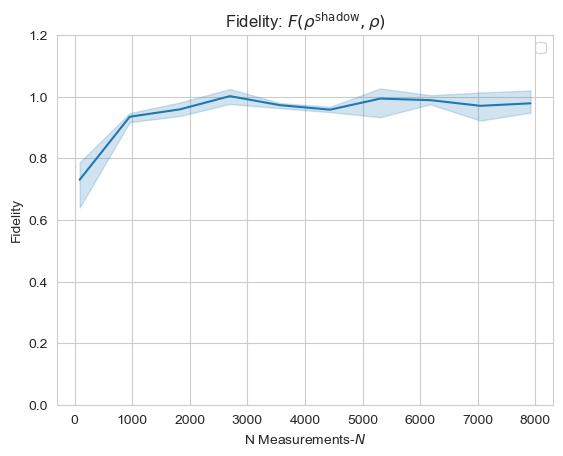

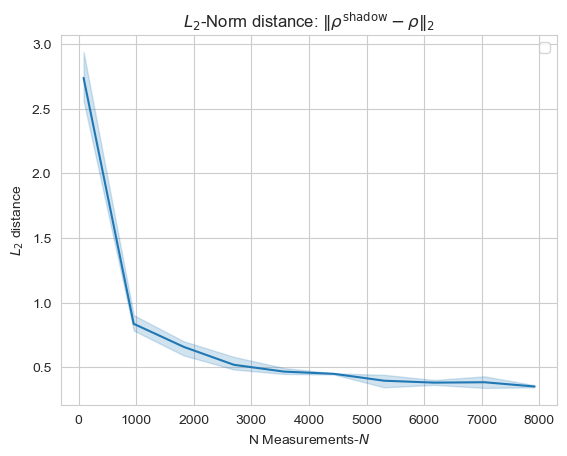

In [9]:
sns.set_style("whitegrid")
plt.figure()
sns.lineplot(
    data=df,
    x="n_measurement",
    y="fidelity",
)
plt.xlabel("Number of Measurements")
plt.legend()
plt.ylim(0, 1.2)
plt.title(r"Fidelity: $F(\rho^{\rm shadow}, \rho)$")
plt.xlabel(r"N Measurements-$N$")
plt.ylabel(r"Fidelity")


plt.figure()
sns.lineplot(
    data=df,
    x="n_measurement",
    y="operator_2_norm",
)
plt.title(r"$L_2$-Norm distance: $\|\rho^{\rm shadow} - \rho\|_2$")
plt.xlabel(r"N Measurements-$N$")
plt.ylabel(r"$L_2$ distance")
plt.legend()

## Use Classical Shadows to Estimate Expectation Values of Observables

To estimate the expectation value of some observable, we simply replace the unknown quantum state $\rho$ with a classical shadow $\hat{\rho}$. Since classical shadows are random, this produces a random variable that yields the correct prediction in expectation:
\begin{align}
    \hat{o}_i = \mathrm{Tr}(O_i\hat{\rho})\qquad\mathrm{obeys}\qquad \mathrm{Tr}(O_i\rho)\equiv \mathbb{E}[\hat{o}_i],\qquad~~~~ 1\leq i\leq M.
\end{align}
 
One can prove that a snapshot can correctly predict **any** linear functions $f(\rho)$ of state, e.g. expectation values of obsevables $O_i$, i.e. $o_i=\mathrm{Tr}(O_i\rho)$, by taking average over the repeatedly $N$ independent classical shadows, 

\begin{align}
\hat{o}_i(N)=\mathbb{E}_{j\in N}(\hat{o}_i^{(j)}\hat{\rho}_j)
\end{align}

Actually in practical, with the statistical method of taking an average called "median of means" to achieve an acceptable failure probability of estimation, which need $R=NK$ snapshots acctually,
\begin{align}
\hat{o}_i(N,K):=\mathrm{median}\{\hat{o}_i^{(1)},\cdots,\hat{o}_i^{(K)}\}~~\mathrm{where}~~\hat{o}_i^{(j)}=N^{-1}\sum_{k=N(j-1)+1}^{Nj}\mathrm{Tr}(O_i\hat{\rho}_k),\qquad \forall~1\leq j\leq K
\end{align}

 Now let's assume that our list of observables are a set of nearest nearist neighbour interactions on a 1D lattice $\{\}$, i.e. $O_i=Z_iZ_{i+1}$, where $Z_i$ is the Pauli-Z operator on the $i$th qubit. We can use the classical shadow to estimate the expectation value of the observable $O_i$ by simply replacing the unknown quantum state $\rho$ with a classical shadow $\hat{\rho}$, which is a random variable that yields the correct prediction in expectation:

In [10]:
from mitiq import Observable, PauliString

"""
 define the observables \{X_iX_{i+1}\}_{i\leq n-1}
"""

list_of_observables = (
    [cirq.X(qubits[i]) * cirq.X(qubits[i + 1]) for i in range(num_qubits - 1)]
    + [
        cirq.Y(qubits[i]) * cirq.Y(qubits[i + 1])
        for i in range(num_qubits - 1)
    ]
    + [
        cirq.Z(qubits[i]) * cirq.Z(qubits[i + 1])
        for i in range(num_qubits - 1)
    ]
)
# define the libservables in mitiq
mitiq_observables = []
identity_string = ["I" for i in range(num_qubits)]
for pauli in ["X", "Y", "Z"]:
    for i in range(num_qubits - 1):
        pauli_string = deepcopy(identity_string)
        pauli_string[i] = pauli
        pauli_string[i + 1] = pauli
        pauli_string = "".join(pauli_string)
        mitiq_observables.append(Observable(PauliString(pauli_string)))
for observables in list_of_observables:
    print(observables)
# print the type of the observables

X(q(0))*X(q(1))
X(q(1))*X(q(2))
X(q(2))*X(q(3))
Y(q(0))*Y(q(1))
Y(q(1))*Y(q(2))
Y(q(2))*Y(q(3))
Z(q(0))*Z(q(1))
Z(q(1))*Z(q(2))
Z(q(2))*Z(q(3))


In [11]:
"""
Solve for the exact expectation values with mitiq
-----------------------------------------------
$$\langle O\rangle_{\rho} = \mathrm{Tr}(\rho O)$$
"""
from functools import partial
from mitiq.interface import mitiq_cirq

expval_exact = []
for i, obs in enumerate(mitiq_observables):
    exp = obs.expectation(
        simple_test_circuit(params, qubits),
        execute=partial(mitiq_cirq.compute_density_matrix, noise_level=(0.0,)),
    )

    expval_exact.append(exp)

In the scenario of a random Pauli measurement, where a set of local observables acts on neighboring strings, denoted by $\{X_j X_{j+1},Y_jY_{j+1},Z_jZ_{j+1}\}_{j\leq n-1}$, the expected value of the local observable $\sigma_j\sigma_{j+1}$, where $\sigma\in\{I,X,Y,Z\}$, can be expressed as follows:

\begin{align}
\mathrm{Tr}(\sigma_i\sigma_{i+1}\hat{\rho})=3\prod_{i\in\mathrm{obs}}\langle\hat{b}_i|U_i\sigma_iU_i^\dagger|\hat{b}_i\rangle ,\qquad|\hat{b}_i\rangle\in\{0,1\}, ~~0\leq i\leq n-1.
\end{align}
\
Here,
\begin{align}
\langle{b}_i|U_i\sigma_iU_i^\dagger|{b}_i\rangle
=\langle{b}_i|Z|{b}_i\rangle\cdot\delta(\sigma_i,U_i^\dagger Z U_i)&\qquad \mathrm{if}~~ \sigma_i\in\{X,Y,Z\} \\    
\end{align}
When we realize this code, it's important to consider that we record the equivalent Pauli measurement in the case of local Pauli measurement. The expectation value of the observable $O_i$ can be simply computed by counting the number of exact matches between the observable and the classical shadow, and then multiplying the result by the appropriate sign given the measurement result $b_i=\pm 1$. If the operator in the observable does not match the random Pauli measurement (recorded as output in the program) that has been performed on the particular qubit, i.e. if $u_i:= U_i^\dagger Z U_i \neq \sigma_i$, the result vanishes.

Consequently, computing the mean estimator involves counting the number of exact matches between the observable and the classical shadow, and then multiplying the result by the appropriate sign. In the following, we present the function `expectation_estimation_shadow`, which allows for estimating any observable based on a classical shadow. This is realised by the main function `execute_with_shadows` when *state_reconstruction =* **Fause**.

## Shadow Estimation Bound on Estimation of Expectation Values of Observables

The shadow estimation bound of operator expectation values is given by the following theorem:
_________________________________________________________________________
#### Theorem: 
A sequence of observables $\{O_i\}_{i\leq M}$ acting on $n$ qubits 
\begin{align}
K=2\log(2M \delta^{-1})\qquad N=34\epsilon^{-2}\max_i\left\|O_i-\frac{\mathrm{Tr}(O_i)\mathbb{I}}{2^n}\right\|_{\mathrm{shadow}}^2
\end{align}
with error rates $\delta,\epsilon\leq 1$. 

Then, with probability at least $1-\delta$, a collection of $R= NK$ independent classical shadows $\{\hat{\rho}_k\}_{k\leq NK}$ allow for accurately predicting all features via median of means, i.e.
\begin{align}
|\hat{o}_i(N,K)-\mathrm{Tr}(O_i\rho)|\leq \epsilon\qquad \forall~1\leq i\leq M
\end{align}
_________________________________________________________________________


The general form of the shadow norm $\|\cdot\|_{\mathrm{shadow}}$ is not clear and depends on the ensemble $\mathcal{U}$ from which we sampled the unitaries, but there are special cases where the shadow norm computable. For example, if we sample from the local Clifford group $\mathcal{U}=\mathrm{CL}(2)^n$, the shadow norm is given by: 
\begin{align}
\parallel O \parallel_{\mathrm{shadow}}\leq 4^{w}\parallel O \parallel^2,\qquad O\mathrm{~acting~on~}w\mathrm{~qubits}
\end{align}
 The shadow norm, in this situation, correlates with the operator ($L_2$) norm. This guarantees the accurate prediction of many local observables from only a much smaller number of measurements. We realize the bound of the shadow estimation in the function `shadow_estimation_bound`, which is called in the main function `execute_with_shadows` when *state_reconstruction =* **False**. 

In [12]:
"""
Minimum number of snapshots $$N$$ required for predicting the expectation values of the observables with error rate $$\epsilon$$.
"""
# create a grid of errors epsilon = 0.2, 0.4, 0.6, 0.8 defined as epsilon in the Theorem
epsilon_grid = [1 - 0.2 * x for x in range(0, 5, 1)]
n_total_measurementss = []
expectation_value_shadow = []
# define failure_rate delta in Theorem
failure_rate = 0.01
# For each error in epsilon_grid
for error in epsilon_grid:
    # get the number of samples needed so that the absolute error < epsilon.
    r, k = calculate_shadow_bound(error, list_of_observables, failure_rate)
    n_total_measurementss.append(r)
    # calculate a measurement_outcomes of the appropriate size
    # measurement_outcomes = get_z_basis_measurement(simple_test_circuit(params,qubits), r,)

    # estimate all the observables in {O_i}_i with error rate epsilon and failure rate delta
    output = execute_with_shadows(
        circuit,
        measurement_total_rounds=r,
        K2=k,
        observables=list_of_observables,
        state_reconstruction=False,
    )
    expectation_value_shadow.append(output["est_observables"])

    # totle number of snpshots required for error rate = epsilon
    print(
        f"{r} totel number of snapshots required for error rate {int((error+1e-10)*10)/10}"
    )

Measurement:   0%|          | 0/510 [00:00<?, ?it/s]

510 totel number of snapshots required for error rate 1.0


Measurement:   0%|          | 0/797 [00:00<?, ?it/s]

797 totel number of snapshots required for error rate 0.8


Measurement:   0%|          | 0/1416 [00:00<?, ?it/s]

1416 totel number of snapshots required for error rate 0.6


Measurement:   0%|          | 0/3186 [00:00<?, ?it/s]

3186 totel number of snapshots required for error rate 0.4


Measurement:   0%|          | 0/12743 [00:00<?, ?it/s]

12743 totel number of snapshots required for error rate 0.2


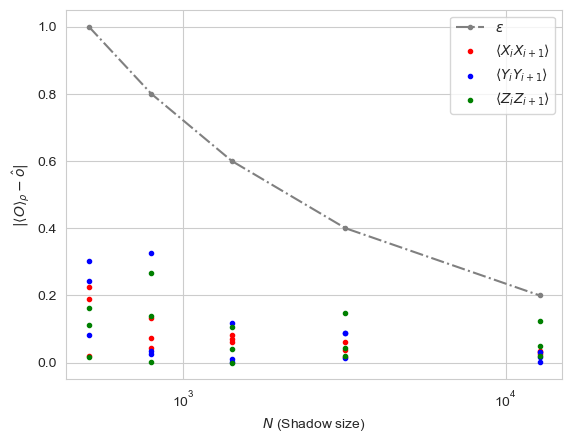

In [13]:
import matplotlib.pyplot as plt

# Plot exact expectation values
for i, obs in enumerate(expval_exact):
    if i < len(expval_exact) // 3:
        color = "red"
    elif len(expval_exact) // 3 <= i < 2 * len(expval_exact) // 3:
        color = "blue"
    else:
        color = "green"
    obs = expval_exact[i]
    for j, error in enumerate(epsilon_grid):
        plt.scatter(
            [n_total_measurementss[j]],
            [np.abs(obs - expectation_value_shadow[j][i])],
            marker=".",
            color=color,
        )
plt.plot(
    n_total_measurementss,
    [e for e in epsilon_grid],
    linestyle="-.",
    color="gray",
    label=rf"$\epsilon$",
    marker=".",
)
plt.xlabel(r"$N$ (Shadow size) ")
plt.ylabel(r"$|\langle O \rangle_{\rho} - \hat{o}|$")

# legend dots
plt.scatter(
    [], [], marker=".", color="red", label=r"$\langle X_i X_{i+1} \rangle$"
)
plt.scatter(
    [], [], marker=".", color="blue", label=r"$\langle Y_i Y_{i+1} \rangle$"
)
plt.scatter(
    [], [], marker=".", color="green", label=r"$\langle Z_i Z_{i+1} \rangle$"
)
plt.legend()
#
plt.xscale("log")
plt.show()